# QGAN

One of the main objectives of CERN Quantum Technology Initiative (CERN QTI) is to investigate if quantum computing can be used in the field of high-energy physics. In this project we will explore the idea behing Quantum Generative Adversarial Networks (QGANs) as a way to generate High Energy Physics (HEP) data. 

QGANs are fundamentally composed of two Quantum Neural Networks (QNNs) - a generator and a discriminator one - that compete between each other. The generative network generates candidates while the discriminative network evaluates them. The contest operates in terms of data distributions. Typically, the generative network learns to map from a latent space to a data distribution of interest, while the discriminative network distinguishes candidates produced by the generator from the true data distribution. The generative network's training objective is to increase the error rate of the discriminative network (i.e., "fool" the discriminator network by producing novel candidates that the discriminator thinks are not synthesized (are part of the true data distribution)).

This project will focus on the technical implementation details of a QGAN that can generate a 2-qubit state.

In [1]:
import uproot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import minmax_scale
from qutip import *

import numpy as np
import pandas as pd
import pennylane as qml
import tensorflow as tf
%matplotlib inline
np.set_printoptions(suppress=True)

## Prepare real data: Stop

In [2]:
path = "/Users/ketchum/Desktop/STOP_nTuples/"
tuples = "nTuples17_nanoAOD_v2021-10-15_test/"

signal = "T2DegStop_550_520_bdt"
treename="bdttree"

branches = ["LepPt","LepChg","LepEta","Met","Jet1Pt","mt","HT", "NbLoose","Njet", "JetHBpt", "DrJetHBLep",
              "JetHBDeepCSV","XS","Nevt","Event","weight"]

preSel = "(LepPt < 30) & (Met > 280) & (HT > 200) & (Jet1Pt > 110) & ((DPhiJet1Jet2 < 2.5) | (Jet2Pt < 60)) & (isTight == 1)\
         & (Met < 1000) & (mt < 300)"

In [3]:
# load root files
sgTree = uproot.open(path + tuples + signal +".root:"+treename)

# select important events
sgDict = sgTree.arrays(branches,preSel,library="np")

In [4]:
lumi = 414759
splitFactor = 2

sgLepPt  = sgDict["LepPt"]
sgLepChg = sgDict["LepChg"]
sgLepEta = sgDict["LepEta"]

sgMet = sgDict["Met"]
sgmt  = sgDict["mt"]
sgDR = sgDict["DrJetHBLep"]

sgW = sgDict["XS"]/sgDict["Nevt"]
wei = sgW*lumi*splitFactor

In [5]:
plotFeatures = False

if plotFeatures:
    plt.rcParams['figure.figsize'] = [15,10]
    fig, axs = plt.subplots(2, 3)
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[0, 2]
    ax4 = axs[1, 0]
    ax5 = axs[1, 1]
    ax6 = axs[1, 2]
    
    label=["Signal"]
    
    binning=np.arange(0,30,1)
    ax1.hist(sgLepPt, weights = wei,color = "blue", alpha=0.25)
    ax1.legend(label, loc='best')
    ax1.set_xlim([0, 30])
    ax1.set_xlabel("$p_T(Lepton)$ [GeV]")

    binning=np.arange(-2,2,0.5)
    ax2.hist(sgLepChg, weights = wei,color = "blue", alpha=0.25)
    ax2.legend(label, loc='best')
    ax2.set_xlim([-1.5, 1.5])
    ax2.set_xlabel("Lepton Charge")

    minb=-3
    maxb=3
    nbins=20.
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax3.hist(sgLepEta, binning, weights = wei,color = "blue", alpha=0.25)
    ax3.legend(label, loc='best')
    ax3.set_xlim([-3, 3])
    ax3.set_xlabel("$\eta$ (Lepton)")

    minb=280
    maxb=1000
    nbins=36
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax4.hist(sgMet, binning, weights = wei,color = "blue", alpha=0.25)
    ax4.legend(label, loc='best')
    ax4.set_xlim([280, 1000])
    ax4.set_xlabel("$p_T^{miss}$ [GeV]")
    
    minb=0
    maxb=300
    nbins=20
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax5.hist(sgmt, binning, weights = wei,color = "blue", alpha=0.25)
    ax5.legend(label, loc='best')
    ax5.set_xlim([0, 300])
    ax5.set_xlabel("$M_T$ [GeV]")
    
    minb=0
    maxb=4
    nbins=20
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax6.hist(sgDR, binning, weights = wei,color = "blue", alpha=0.25)
    ax6.legend(label, loc='best')
    ax6.set_xlim([0, 4])
    ax6.set_xlabel("$\Delta R(J_{B1},lepton)$")

In [6]:
doDataFrame = False 

if doDataFrame:
    sgDF = pd.DataFrame(sgDict)
    display(sgDF)

In [7]:
lepChg_to_phi = minmax_scale(sgLepChg, feature_range=(0, np.pi))
lepPt_to_theta = minmax_scale(sgLepPt, feature_range=(0, np.pi))
lepEta_to_phi = minmax_scale(sgLepEta, feature_range=(0, 2*np.pi))
Met_to_theta = minmax_scale(sgMet, feature_range=(0, np.pi))

#lepPt_to_phi    = minmax_scale(sgLepPt, feature_range=(0, np.pi))
#lepChg_to_theta = minmax_scale(sgLepChg, feature_range=(0, np.pi))
#lepEta_to_omega = minmax_scale(sgLepEta, feature_range=(0, np.pi)) #2*np.pi))

#Met_to_phi  = minmax_scale(sgMet, feature_range=(0, np.pi))
#mt_to_theta = minmax_scale(sgmt, feature_range=(0, np.pi))
#DR_to_omega = minmax_scale(sgDR, feature_range=(0, np.pi))

In [8]:
plotAngleTransform = False

if plotAngleTransform:
    plt.rcParams['figure.figsize'] = [15,10]
    fig, axs = plt.subplots(2, 3)
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[0, 2]
    ax4 = axs[1, 0]
    ax5 = axs[1, 1]
    ax6 = axs[1, 2]
    
    label=["Signal Transformed"]
   
    ax1.hist(lepPt_to_phi, weights = wei,color = "blue", alpha=0.25)
    ax1.legend(label, loc='best')
    ax1.set_xlim([0, np.pi])
    ax1.set_xlabel("$p_T(Lepton)$ [$\phi$ rad]")
    
    ax2.hist(lepChg_to_theta, weights = wei,color = "blue", alpha=0.25)
    ax2.legend(label, loc='best')
    ax2.set_xlim([0, np.pi])
    ax2.set_xlabel("Lepton Charge [$\Theta$ rad]")

    minb=0
    maxb=n2*np.pi#np.pi
    nbins=20.
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax3.hist(lepEta_to_omega, binning, weights = wei,color = "blue", alpha=0.25)
    ax3.legend(label, loc='best')
    ax3.set_xlim([0, np.pi]) #2*np.pi])
    ax3.set_xlabel("$\eta$ (Lepton) [$\omega$ rad]")      
    
    minb=0
    maxb=np.pi
    nbins=36
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax4.hist(Met_to_phi, binning, weights = wei,color = "blue", alpha=0.25)
    ax4.legend(label, loc='best')
    ax4.set_xlim([0, np.pi])
    ax4.set_xlabel("$p_T^{miss}$ [$\phi$ rad]")
    
    minb=0
    maxb=np.pi
    nbins=20
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax5.hist(mt_to_theta, binning, weights = wei,color = "blue", alpha=0.25)
    ax5.legend(label, loc='best')
    ax4.set_xlim([0, np.pi])
    ax5.set_xlabel("$M_T$ [$\Theta$ rad]")
    
    minb=0
    maxb=np.pi
    nbins=20
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax6.hist(DR_to_omega, binning, weights = wei,color = "blue", alpha=0.25)
    ax6.legend(label, loc='best')
    ax4.set_xlim([0, np.pi])
    ax6.set_xlabel("$\Delta R(J_{B1},lepton)$ [$\omega$ rad]")

In [9]:
def spherical_to_cartesian(theta,phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x,y,z

def cartesian_to_spherical(x,y,z):
    if x > 0:
        phi = np.arctan(y/x)
    elif x < 0 and y >= 0:
        phi = np.arctan(y/x) + np.pi
    elif x < 0 and y < 0:
        phi = np.arctan(y/x) - np.pi
    elif x == 0 and y > 0:
        phi = np.pi/2
    elif x == 0 and y < 0:
        phi = -np.pi/2
    elif x == 0 and y == 0:
        phi = 0 # Undefined

    theta = np.arctan((np.sqrt(x**2+y**2))/z)
    return theta, phi

In [10]:
tlist = np.linspace(0, 1, 40)
#nrm = mpl.colors.Normalize()
#colors = cm.cool(nrm(tlist))
colors = cm.cool(tlist)

In [11]:
generateAssets = False

if generateAssets:
    bloch1 = Bloch()
    bloch2 = Bloch()
    c = 0
    for i in range(0,3400,85):
        x1,y1,z1=spherical_to_cartesian(lepPt_to_theta[i],lepChg_to_phi[i])
        x2,y2,z2=spherical_to_cartesian(Met_to_theta[i],lepEta_to_phi[i])
        vec1=[x1,y1,z1]
        vec2=[x2,y2,z2]
        #vec1=[lepPt_to_phi[i],lepChg_to_theta[i],lepEta_to_omega[i]]
        #vec2=[Met_to_phi[i],mt_to_theta[i],DR_to_omega[i]]

        bloch_ev_1 = Bloch()
        bloch_ev_2 = Bloch()
        bloch1.add_vectors(vec1)
        bloch2.add_vectors(vec2)
        bloch_ev_1.add_vectors(vec1)
        bloch_ev_2.add_vectors(vec2)
        bloch_ev_1.vector_color = list(colors[c:])
        bloch_ev_2.vector_color = list(colors[c:])
        bloch_ev_1.save("assets/bloch_event"+str(i)+"_1.png")
        bloch_ev_2.save("assets/bloch_event"+str(i)+"_2.png")
        c+=1

    bloch1.vector_color = list(colors)
    bloch2.vector_color = list(colors)    

    bloch1.save("assets/bloch1.png")
    bloch2.save("assets/bloch2.png")

In [12]:
ev_idx = 42

ev_idx = 2040
ev_idx = 680

| Event 680 Bloch 1: Lepton Charge and pT  | Event 680 Bloch 2: Lepton Eta and Met |
|-|-|
|<div> <img src="assets/bloch_event680_1.png" width="250"/></div>|<div><img src="assets/bloch_event680_2.png" width="250"/></div>|

| Event 2040 Bloch 1: Lepton Charge and pT  | Event 2040 Bloch 2: Lepton Eta and Met |
|-|-|
|<div> <img src="assets/bloch_event2040_1.png" width="250"/></div>|<div><img src="assets/bloch_event2040_2.png" width="250"/></div>|

| Bloch 1: Lepton Charge and pT  | Bloch 2: Lepton Eta and Met |
|-|-|
|<div> <img src="assets/bloch1.png" width="250"/></div>|<div><img src="assets/bloch2.png" width="250"/></div>|



In [13]:
angles=[lepPt_to_theta[ev_idx],lepChg_to_phi[ev_idx],Met_to_theta[ev_idx],lepEta_to_phi[ev_idx]]

x1,y1,z1=spherical_to_cartesian(lepPt_to_theta[ev_idx],lepChg_to_phi[ev_idx])
x2,y2,z2=spherical_to_cartesian(Met_to_theta[ev_idx],lepEta_to_phi[ev_idx])

In [14]:
#ev_idx = 0
#angles=[lepPt_to_phi[ev_idx],lepChg_to_theta[ev_idx],lepEta_to_omega[ev_idx],
#        Met_to_phi[ev_idx],mt_to_theta[ev_idx],DR_to_omega[ev_idx]]

In [15]:
print(angles)

[0.6196836, 3.1415927, 1.8112353, 4.293872]


## Quantum

Using a **5-qubit** simulator device running in Cirq:
- Qubit **0 & 1**: the 2 qubit state that we are trying to generate
- Qubit **2 & 3**: the generator's playground
- Qubit **4**: the generator's guess


In [16]:
#dev = qml.device('cirq.simulator', wires=5)
dev = qml.device('qiskit.aer', wires=5)

In [17]:
def real(angles, **kwargs):
    #qml.Hadamard(wires=0)
    qml.RY(angles[0], wires=0)
    qml.RZ(angles[1], wires=0)
    qml.RY(angles[2], wires=1)
    qml.RZ(angles[3], wires=1)
    #qml.CNOT(wires=[0,1])      # should 2 qubits be entangled?

def real_rand(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.RX(angles[0], wires=0)
    qml.RY(angles[1], wires=0)
    qml.RZ(angles[2], wires=0)
    qml.RX(angles[3], wires=0)
    qml.RY(angles[4], wires=0)
    qml.RZ(angles[5], wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RX(angles[3], wires=1)
    qml.RY(angles[4], wires=1)
    qml.RZ(angles[5], wires=1)
    qml.RX(angles[0], wires=1)
    qml.RY(angles[1], wires=1)
    qml.RZ(angles[2], wires=1)

## Generator

<div> <img src="assets/generator.png"/></div>

In [18]:
# Define the generator
# Wires 0 and 1 are the 2 qubit state.
# We need 45 weights: 11 x 3 generator layers + 11 for final generation layer

def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0,1])
    qml.Barrier(wires=[0,4],only_visual=True)
    generator_layer(w[:11])
    generator_layer(w[11:22])
    generator_layer(w[22:33])
    qml.RX(w[33], wires=0)
    qml.RY(w[34], wires=0)
    qml.RZ(w[35], wires=0)
    qml.RX(w[36], wires=1)
    qml.RY(w[37], wires=1)
    qml.RZ(w[38], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[39], wires=0)
    qml.RY(w[40], wires=0)
    qml.RZ(w[41], wires=0)
    qml.RX(w[42], wires=1)
    qml.RY(w[43], wires=1)
    qml.RZ(w[44], wires=1)

def generator_layer(w):
    qml.RY(w[0], wires=0)
    qml.RY(w[1], wires=1)
    qml.RY(w[2], wires=2)
    qml.RY(w[3], wires=3)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.RZ(w[6], wires=2)
    qml.RZ(w[7], wires=3)
    qml.MultiRZ(w[8], wires=[0, 1])
    qml.MultiRZ(w[9], wires=[2, 3])
    qml.MultiRZ(w[10], wires=[1, 2])
    # 11 weights

## Discriminator

<div> <img src="assets/discriminator.png" width="750"/></div>

In [19]:
# The discriminator acts on wires 0, 1, and 4
# We need 27 weights: 8 x 3 generator layers + 3 for final descrimination layer

def discriminator(w, **kwargs):
    qml.Barrier(wires=[0,4],only_visual=True)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0,1])
    qml.Barrier(wires=[0,4],only_visual=True)
    discriminator_layer(w[:8])
    discriminator_layer(w[8:16]) 
    discriminator_layer(w[16:24])
    qml.RX(w[24], wires=4)
    qml.RY(w[25], wires=4)
    qml.RZ(w[26], wires=4)
    
def discriminator_layer(w, **kwargs):
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RX(w[2], wires=4)
    qml.RZ(w[3], wires=0)
    qml.RZ(w[4], wires=1)
    qml.RZ(w[5], wires=4)
    qml.MultiRZ(w[6], wires=[0, 1])
    qml.MultiRZ(w[7], wires=[1, 4])
    # 8 weights

In [20]:
@qml.qnode(dev, interface='tf')
def real_disc_circuit(angles, disc_weights):
    real(angles)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(4))

@qml.qnode(dev, interface='tf')
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(4))    

In [21]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(angles, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2.
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2.
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

In [22]:
np.random.seed(42)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 44) + \
                   np.random.normal(scale=eps, size=(45,))
init_disc_weights = np.random.normal(size=(27,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

In [23]:
print("Probability classify real as real: {:.3f} %".format(prob_real_true(disc_weights).numpy()*100))
print("Probability classify fake as real: {:.3f} %".format(prob_fake_true(gen_weights, disc_weights).numpy()*100))

Probability classify real as real: 91.504 %
Probability classify fake as real: 57.324 %


In [24]:
opt = tf.keras.optimizers.SGD(0.4)
disc_loss = []
gen_loss = []

In [25]:
def train_disc(it,disc_loss):
    print("== Training discriminator")
    cost = lambda: disc_cost(disc_weights)

    for step in range(it+1):
        opt.minimize(cost, disc_weights)
        cost_val = cost().numpy()
        disc_loss += [cost_val]
        #if step % int((it/5)) == 0:    
        if step % 3 == 0:    
            print("Step {}: cost = {:.6f}".format(step, cost_val))
            print(" Prob. real as real: {:.3f} %".format(prob_real_true(disc_weights).numpy()*100))
            print(" Prob. fake as real: {:.3f} %".format(prob_fake_true(gen_weights, disc_weights).numpy()*100))

In [26]:
def train_gen(it,gen_loss):
    print("== Training generator")
    cost = lambda: gen_cost(gen_weights)

    for step in range(it+1):
        opt.minimize(cost, gen_weights)
        cost_val = cost().numpy()
        gen_loss += [cost_val]
        #if step % int((it/5)) == 0:    
        if step % 3 == 0:
            print("Step {}: Prob. fake as real = {:.3f} %".format(step, abs(cost_val*100)))

In [27]:
train_disc(20,disc_loss)
train_gen(5,gen_loss)

== Training discriminator
Step 0: cost = -0.446289
 Prob. real as real: 84.961 %
 Prob. fake as real: 38.477 %
Step 3: cost = -0.620117
 Prob. real as real: 77.344 %
 Prob. fake as real: 11.621 %
Step 6: cost = -0.666992
 Prob. real as real: 77.148 %
 Prob. fake as real: 6.250 %
Step 9: cost = -0.694336
 Prob. real as real: 72.656 %
 Prob. fake as real: 6.543 %
Step 12: cost = -0.677734
 Prob. real as real: 74.707 %
 Prob. fake as real: 6.934 %
Step 15: cost = -0.677734
 Prob. real as real: 75.684 %
 Prob. fake as real: 6.934 %
Step 18: cost = -0.706055
 Prob. real as real: 74.707 %
 Prob. fake as real: 5.664 %
== Training generator
Step 0: Prob. fake as real = 16.797 %
Step 3: Prob. fake as real = 96.680 %


In [28]:
train_disc(20,disc_loss)
train_gen(5,gen_loss)

== Training discriminator
Step 0: cost = 0.194336
 Prob. real as real: 80.859 %
 Prob. fake as real: 99.609 %
Step 3: cost = -0.012695
 Prob. real as real: 88.184 %
 Prob. fake as real: 87.695 %
Step 6: cost = -0.344727
 Prob. real as real: 89.160 %
 Prob. fake as real: 54.980 %
Step 9: cost = -0.586914
 Prob. real as real: 88.281 %
 Prob. fake as real: 28.320 %
Step 12: cost = -0.687500
 Prob. real as real: 87.207 %
 Prob. fake as real: 19.824 %
Step 15: cost = -0.699219
 Prob. real as real: 86.230 %
 Prob. fake as real: 19.141 %
Step 18: cost = -0.687500
 Prob. real as real: 86.230 %
 Prob. fake as real: 16.504 %
== Training generator
Step 0: Prob. fake as real = 57.617 %
Step 3: Prob. fake as real = 99.414 %


In [29]:
train_disc(20,disc_loss)
train_gen(5,gen_loss)
#stop here

== Training discriminator
Step 0: cost = 0.059570
 Prob. real as real: 91.797 %
 Prob. fake as real: 96.777 %
Step 3: cost = -0.096680
 Prob. real as real: 90.723 %
 Prob. fake as real: 81.934 %
Step 6: cost = -0.195312
 Prob. real as real: 87.598 %
 Prob. fake as real: 69.336 %
Step 9: cost = -0.322266
 Prob. real as real: 87.402 %
 Prob. fake as real: 57.715 %
Step 12: cost = -0.418945
 Prob. real as real: 87.012 %
 Prob. fake as real: 44.629 %
Step 15: cost = -0.497070
 Prob. real as real: 85.449 %
 Prob. fake as real: 38.477 %
Step 18: cost = -0.510742
 Prob. real as real: 84.180 %
 Prob. fake as real: 30.664 %
== Training generator
Step 0: Prob. fake as real = 77.832 %
Step 3: Prob. fake as real = 99.219 %


In [30]:
#train_disc(20,disc_loss)
#train_gen(5,gen_loss)

In [31]:
#train_disc(20,disc_loss)
#train_gen(5,gen_loss)

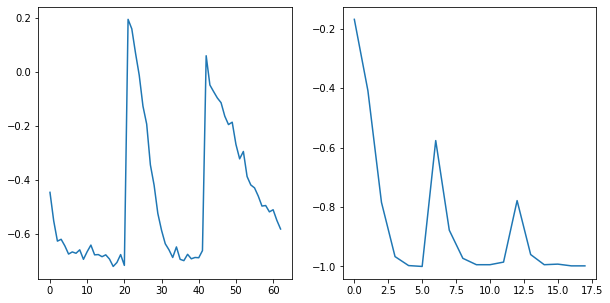

In [32]:
plt.rcParams['figure.figsize'] = [10,5]

fig, axs = plt.subplots(1, 2)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(disc_loss)
ax2.plot(gen_loss)

In [33]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0),qml.PauliX(1), qml.PauliY(1), qml.PauliZ(1)]

bloch_vector_real = qml.map(real, obs, dev, interface="tf")
bloch_vector_fake = qml.map(generator, obs, dev, interface="tf")

bv_real = bloch_vector_real(angles).numpy()
bv_fake = bloch_vector_fake(gen_weights).numpy()
difference = np.absolute(bv_real - bv_fake)

x1,y1,z1,x2,y2,z2=bv_real
X1,Y1,Z1,X2,Y2,Z2=bv_fake
d1,d2,d3,d4,d5,d6=difference

print("Real Bloch vector:      Q1=[{0:.3f}, {1:.3f}, {2:.3f}] \t Q2=[{3:.3f}, {4:.3f}, {5:.3f}]".format(x1,y1,z1,x2,y2,z2))
print("Generator Bloch vector: Q1=[{0:.3f}, {1:.3f}, {2:.3f}] \t Q2=[{3:.3f}, {4:.3f}, {5:.3f}]".format(X1,Y1,Z1,X2,Y2,Z2))
print("Difference:             Q1=[{0:.3f}, {1:.3f}, {2:.3f}] \t Q2=[{3:.3f}, {4:.3f}, {5:.3f}]".format(d1,d2,d3,d4,d5,d6))

Real Bloch vector:      Q1=[-0.605, -0.016, 0.803] 	 Q2=[-0.436, -0.873, -0.268]
Generator Bloch vector: Q1=[-0.510, -0.080, 0.484] 	 Q2=[-0.350, -0.533, -0.332]
Difference:             Q1=[0.096, 0.064, 0.318] 	 Q2=[0.086, 0.340, 0.064]


In [34]:
def infoQu(name,angles,bv_real,bv_fake):
    theta,phi = angles
    x,y,z=spherical_to_cartesian(theta,phi)
    X,Y,Z = bv_real
    THETA,PHI=cartesian_to_spherical(X,Y,Z)
    Xf,Yf,Zf = bv_fake
    THETAf,PHIf=cartesian_to_spherical(Xf,Yf,Zf)
    
    bloch = Bloch()
    
    vec_og=[x,y,z]
    vec_real=[X,Y,Z]
    vec_fake=[Xf,Yf,Zf]

    bloch.add_vectors(vec_og)
    bloch.add_vectors(vec_real)
    bloch.add_vectors(vec_fake)
    bloch.vector_color = list(colors[0:20:5])
    bloch.show()

    print("==   "+ name +"   ==")
    print("og   | theta,phi: {0:.3f},{1:.3f}".format(theta,phi))
    print("real | THETA,PHI: {0:.3f},{1:.3f}".format(THETA,PHI))
    print("fake | THETA,PHI: {0:.3f},{1:.3f}".format(THETAf,PHIf))
    print("      ______________________________")
    print("og   | x,y,z: {0:.3f} {1:.3f} {2:.3f}".format(x,y,z))
    print("real | X,Y,Z: {0:.3f} {1:.3f} {2:.3f}".format(X,Y,Z))
    print("fake | X,Y,Z: {0:.3f} {1:.3f} {2:.3f}".format(Xf,Yf,Zf))

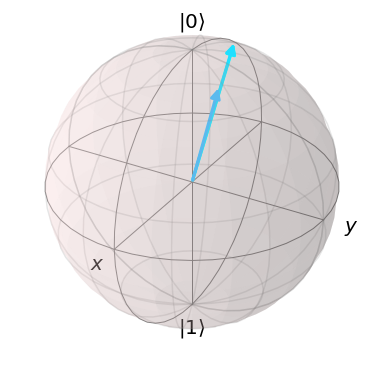

==   Q1   ==
og   | theta,phi: 0.620,3.142
real | THETA,PHI: 0.646,-3.116
fake | THETA,PHI: 0.817,-2.986
      ______________________________
og   | x,y,z: -0.581 -0.000 0.814
real | X,Y,Z: -0.605 -0.016 0.803
fake | X,Y,Z: -0.510 -0.080 0.484


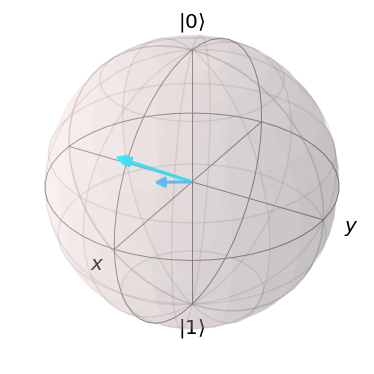

==   Q2   ==
og   | theta,phi: 1.811,4.294
real | THETA,PHI: -1.303,-2.034
fake | THETA,PHI: -1.091,-2.151
      ______________________________
og   | x,y,z: -0.395 -0.887 -0.238
real | X,Y,Z: -0.436 -0.873 -0.268
fake | X,Y,Z: -0.350 -0.533 -0.332


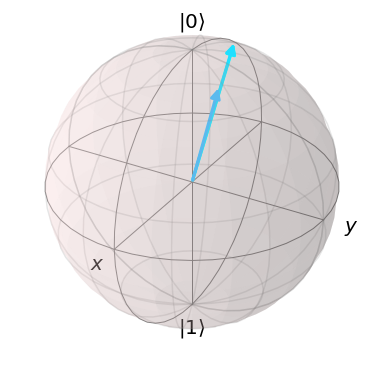

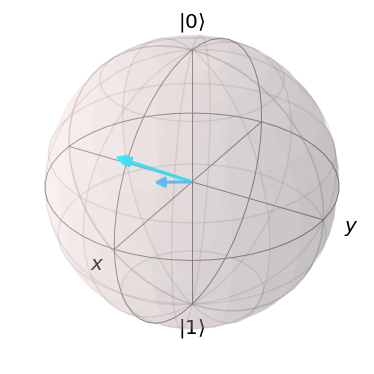

In [35]:
infoQu("Q1",angles[:2],bv_real[:3],bv_fake[:3])
infoQu("Q2",angles[2:],bv_real[3:],bv_fake[3:])

(<Figure size 1728x288 with 1 Axes>, <Axes:>)


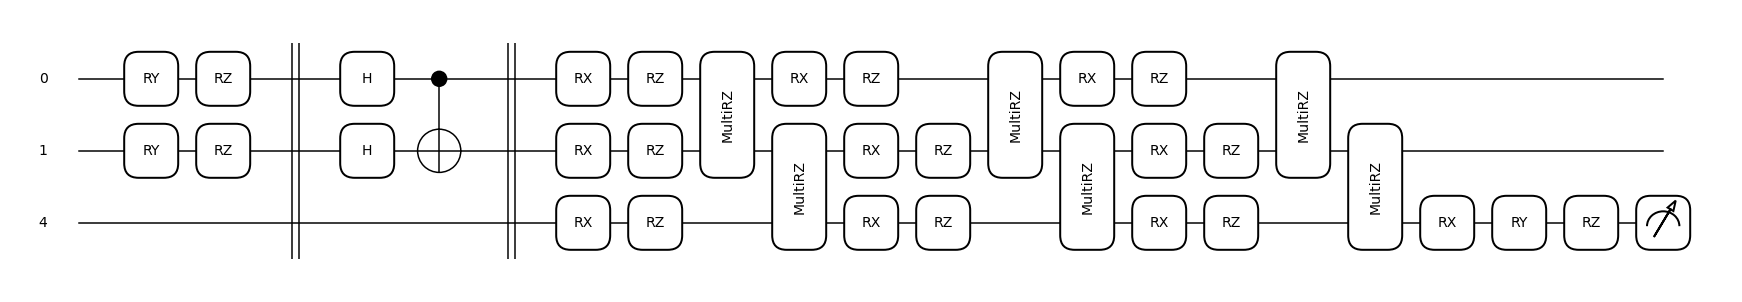

In [36]:
qml.drawer.use_style('black_white')
#print(qml.draw(real_disc_circuit, max_length=80)(angles,disc_weights))
print(qml.draw_mpl(real_disc_circuit)(angles,disc_weights))

(<Figure size 3168x432 with 1 Axes>, <Axes:>)


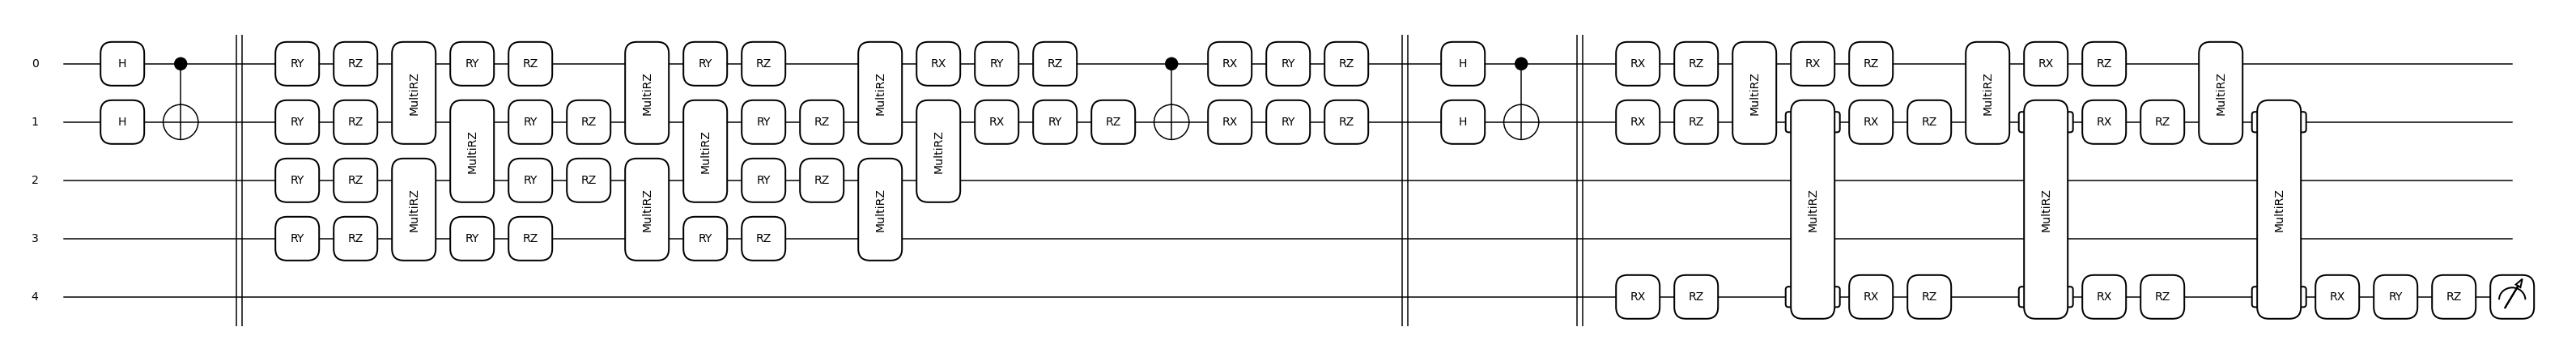

In [37]:
#print(qml.draw(gen_disc_circuit, max_length=80)(gen_weights,disc_weights))
print(qml.draw_mpl(gen_disc_circuit)(gen_weights, disc_weights))

Inspiration:
- https://arxiv.org/pdf/1804.08641.pdf
- https://pennylane.ai/qml/demos/tutorial_QGAN.html
- https://nbviewer.org/github/laurgao/qgan/blob/main/QGAN2.ipynb

More inpiration:
- https://www.nature.com/articles/ncomms5213.pdf
- https://arxiv.org/pdf/1704.05018.pdf
- https://arxiv.org/pdf/1801.01053.pdf
- https://arxiv.org/pdf/1804.00633.pdf
- https://arxiv.org/pdf/1803.11537.pdf